In [1]:
# Imports
%matplotlib notebook
# numpy, matplotlib, seaborn and matplotlib
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# define data path
INPUT_PATH = "data/%s.csv"

In [2]:
# load data
read_rows = 20;
train_date = pd.read_csv('data/train_date.csv',nrows = read_rows)
train_categorical = pd.read_csv('data/train_categorical.csv',nrows = read_rows)
train_numeric = pd.read_csv('data/train_numeric.csv',nrows = read_rows)
test_categorical = pd.read_csv('data/test_categorical.csv', nrows = read_rows)
test_date = pd.read_csv('data/test_date.csv', nrows = read_rows)
test_numeric = pd.read_csv('data/test_numeric.csv', nrows = read_rows)

In [3]:
#get the head
#train_date_hd = train_date.head()
#train_categorical_hd = train_categorical.head()
#test_categorical_hd = test_categorical.head()
#test_date_hd = test_date.head()
#test_numeric = test_numeric.head()

In [4]:
train_date

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,4,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,18,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train_categorical

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test_categorical

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test_date

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,255.45,255.45,255.45,255.45,255.45,255.45,255.45,255.45,255.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,907.34,907.34,907.34,907.34,907.34,907.34,907.34,907.34,907.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15,575.68,575.68,575.68,575.68,575.68,575.68,575.68,575.68,575.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1411.4,1411.4,1411.4,1411.4,1411.4
9,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test_numeric

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,-0.016,-0.026,-0.033,-0.016,0.205,-0.157,0.000,0.008,0.087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,0.030,-0.026,0.003,0.003,-0.013,0.116,-0.007,0.008,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15,-0.010,0.041,-0.215,-0.179,-0.056,0.116,-0.007,-0.072,0.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
9,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train_numeric

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,13,0.003,0.019,0.294,0.312,0.031,0.161,0.022,0.088,-0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,18,-0.016,-0.041,-0.179,-0.179,-0.056,0.161,-0.007,-0.032,-0.082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [39]:
train_numeric.isnull().all(axis=1)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
dtype: bool

In [10]:
# function to calculate failure rate
def get_failure_rate(file_name):
    # will calculate the error rate from data on the file based on response col
    # Respons: 1 = Failed QC , 0 = Passed QC
    rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Response"])
    failure_rate = rows[rows.Response == 1].size / float(rows[rows.Response == 0].size)
    return failure_rate

In [11]:
def explore_data_size():
    # explore the size (rows, cols) of each file
    data_files = ['train_numeric', 'train_date', 'train_categorical', 'test_numeric',
                  'test_date', 'test_categorical']
    stats = []
    for file_name in data_files:
        cols = pd.read_csv(INPUT_PATH % file_name, nrows=1)
        rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Id"])
        stats.append({'File': file_name, 'Rows': rows.shape[0], 'Columns': cols.shape[1]})
    # convert the result into a DataFrame so we can do plotting.
    df = pd.DataFrame(stats, columns=["File", "Rows", "Columns"])
    failure_rate = get_failure_rate('train_numeric')
    df["Error"] = 0
    df.loc[df.File == 'train_numeric', 'Error'] = failure_rate
    return df

In [19]:
df_no_null = explore_data_size()

In [199]:
de_no_null

NameError: name 'de_no_null' is not defined

In [ ]:
# below is the part of training some syntax of python and its library

In [22]:
rows = pd.read_csv(INPUT_PATH % 'train_numeric', usecols=["Response"])

In [23]:
cols = pd.read_csv(INPUT_PATH % 'train_numeric', nrows=1)

In [24]:
cols

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.03,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [25]:
stats = []

In [26]:
stats.append({'File': 'train_numeric', 'Rows': rows.shape[0], 'Columns': cols.shape[1]})

In [27]:
stats[0]

{'Columns': 970, 'File': 'train_numeric', 'Rows': 1183747}

In [40]:
# this part is to explore how many stations, lines, failure rate per station?

In [41]:
def get_features(feature_list):
    # function to group features by station or line of production sinc the convention is:
    # L1_S15_F232 means Line 1, Station 15, Feature 232
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]

    return (line_features, station_features)

In [98]:
def explore_features(data_set_name):
    # how many units processed in each station
    # also percentage of failed/passed QS in each station
    features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    line_features, station_features = get_features(features)
    # create a dataframe cols: station, features_count
    sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
    ldf = pd.DataFrame(list({int(key[1:]): len(line_features[key]) for
                             key in line_features.keys()}.items()),
                       columns=["Line", "FeatureCount"])
    
    stations_plot = sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Fig.4 - Features by Station",
                             figsize=(13,6), fontsize=12)
    
    return line_features, station_features

<IPython.core.display.Javascript object>


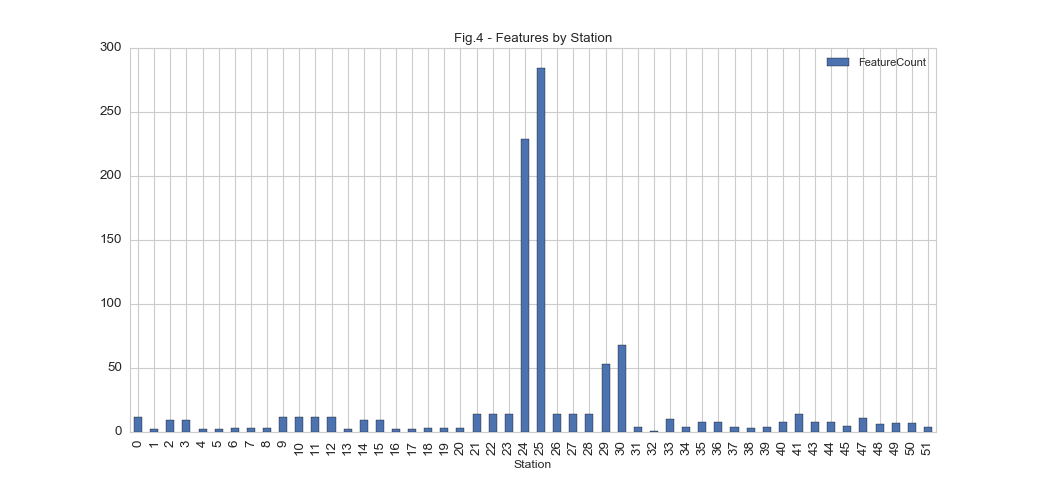

In [99]:
lf, sf = explore_features("train_numeric")

In [44]:
# again this part is to explore some syntax

In [84]:
line_features = {}
station_features = {}

In [46]:
type(line_features)

dict

In [59]:
features = pd.read_csv(INPUT_PATH % 'train_numeric', nrows=1).drop(["Response", "Id"], axis=1).columns.values

In [81]:
stations = set([item.split('_')[1] for item in features])
stations

{'S0',
 'S1',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'S15',
 'S16',
 'S17',
 'S18',
 'S19',
 'S2',
 'S20',
 'S21',
 'S22',
 'S23',
 'S24',
 'S25',
 'S26',
 'S27',
 'S28',
 'S29',
 'S3',
 'S30',
 'S31',
 'S32',
 'S33',
 'S34',
 'S35',
 'S36',
 'S37',
 'S38',
 'S39',
 'S4',
 'S40',
 'S41',
 'S43',
 'S44',
 'S45',
 'S47',
 'S48',
 'S49',
 'S5',
 'S50',
 'S51',
 'S6',
 'S7',
 'S8',
 'S9'}

In [86]:
for s in stations:
        station_features[s] = [item for item in features if '%s_' % s in item]

['S9',
 'S8',
 'S3',
 'S2',
 'S1',
 'S0',
 'S7',
 'S6',
 'S5',
 'S4',
 'S15',
 'S51',
 'S50',
 'S25',
 'S14',
 'S19',
 'S18',
 'S39',
 'S38',
 'S13',
 'S12',
 'S11',
 'S10',
 'S17',
 'S30',
 'S33',
 'S32',
 'S22',
 'S23',
 'S20',
 'S21',
 'S26',
 'S27',
 'S24',
 'S43',
 'S28',
 'S29',
 'S48',
 'S36',
 'S44',
 'S45',
 'S49',
 'S35',
 'S47',
 'S16',
 'S34',
 'S40',
 'S31',
 'S37',
 'S41']

In [89]:
 len(station_features[key]) 

14

In [90]:
key[1:]

'41'

In [ ]:
sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])


In [91]:
sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
sdf

,Station,FeatureCount
0,0,12
1,1,2
2,2,9
3,3,9
4,4,2
5,5,2
6,6,3
7,7,3
8,8,3
9,9,12


In [96]:
sum(sdf.Station)

1238

In [100]:
# continue to explore

In [101]:
def explore_product_by_station(data_set_name):
    # need to see how many product per station
    # features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    # line_features, station_features = get_features(features)
    station_features = sf
    dwb_result = []
    ppbs_result = []
    rows = 0
    # inside this loop we will try to calculate different data sets, this way we only read the
    # files once since it takes a while and produce multiple results
    for station in station_features:
        station_data = pd.read_csv(
            INPUT_PATH % data_set_name,
            usecols=station_features[station] + ['Id', 'Response'])
        
        # need to get how many rows in this data set
        if not rows:
            rows = station_data.shape[0]
        # need to store how many processed units in each station
        # only if all features in that station has value we conside unit processed in this station
        ppbs_result.append(
            {'Station': int(station[1:]),
             'Processed': station_data[station_features[station]].isnull().all(axis=1).sum()})
        
        # data without blanks (dwb): take all rows and drop any row that has any blank
        # in any station column
        dwb = station_data.dropna(how="any")
        dwb_result.append([int(station[1:]), dwb.shape[0],
                       dwb[dwb["Response"] == 1].shape[0],
                       dwb[dwb["Response"] == 0].shape[0]])
        
    # convert list to a dataframe and prepare for the plot
    dwb_df = pd.DataFrame(
        dwb_result, columns=["Station", "Count", "Failed", "Passed"]).sort_values(by=["Station"])
    # calculate the error rate for each station
    dwb_df["Error"] = dwb_df.apply(lambda row: float(row["Failed"]) / row["Passed"], axis=1)
    
    # plot the stacked bar tot product/ station
    my_plot = dwb_df[["Station", "Failed", "Passed"]].plot(kind="bar", stacked=True, x="Station",
        title="Fig:3 - Products by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Record Count")
    
    # plot error rate per station
    my_plot = dwb_df[["Station", "Error"]].plot(
        kind="bar", x="Station",
        title="Fig:4 - Error by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Error %")
    
    # process the ppbs result to see how many products has been process by each station.
    ppbs_df = pd.DataFrame(
        ppbs_result, columns=['Station', 'Processed']).sort(columns=['Station'])
    # calculate the missed product for each station: all count - processed count
    ppbs_df["Missed"] = ppbs_df["Processed"].apply(lambda x: rows - x)
    # the plot
    ppbs_df.plot(x="Station", kind="bar", stacked=True,
            title="Fig: 5 - Products processed by each station",
            figsize=(13,6), fontsize=12)
    



In [102]:
#explore_product_by_station("train_numeric")

KeyboardInterrupt: 

In [ ]:
# start to explore categorial data

In [263]:
train_categorical = pd.read_csv('data/train_categorical.csv',nrows = 3000)

In [264]:
del train_categorical['Id']

In [265]:
train_categorical_zeroes = train_categorical.fillna(0)

In [269]:
train_categorical_zeroes = train_categorical_zeroes.values

In [271]:
np.unique(train_categorical_zeroes[train_categorical_zeroes!=0.0])

array(['T-2147482816', 'T1', 'T128', 'T1310', 'T1372', 'T143', 'T145',
       'T16', 'T16777232', 'T16777557', 'T2', 'T256', 'T3', 'T4', 'T5',
       'T512', 'T65536', 'T786432', 'T8'], dtype=object)

In [253]:
# train_categorical_zeroes_array_row = train_categorical_zeroes.values[9,:]

array(['T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1'], dtype=object)

In [277]:
train_categorical_zeroes_array_row[train_categorical_zeroes_array_row!=0.0].size/float(train_categorical_zeroes_array_row .size)

0.029439252336448597

In [285]:
a={'4':0,'6':0,'7':0.029439252336448597*100,'9':100*0.029439252336448597,'11':100*0.029439252336448597,'13':100*0.029439252336448597,'14':0.029439252336448597,
  '16':100*0.05700934579439252,'18':100*0.029439252336448597,'23':100*0.029439252336448597}

In [286]:
df_a = pd.DataFrame(a, columns = ['4', '6', '7', '9', '11', '13','14','16','18','23'],index=['0'])

# df = pd.DataFrame(raw_data, columns = ['first_name', 'last_name', 'age', 'female', 'preTestScore', 'postTestScore'])

In [287]:
df_a

,4,6,7,9,11,13,14,16,18,23
0,0,0,2.943925,2.943925,2.943925,2.943925,0.029439,5.700935,2.943925,2.943925


<IPython.core.display.Javascript object>


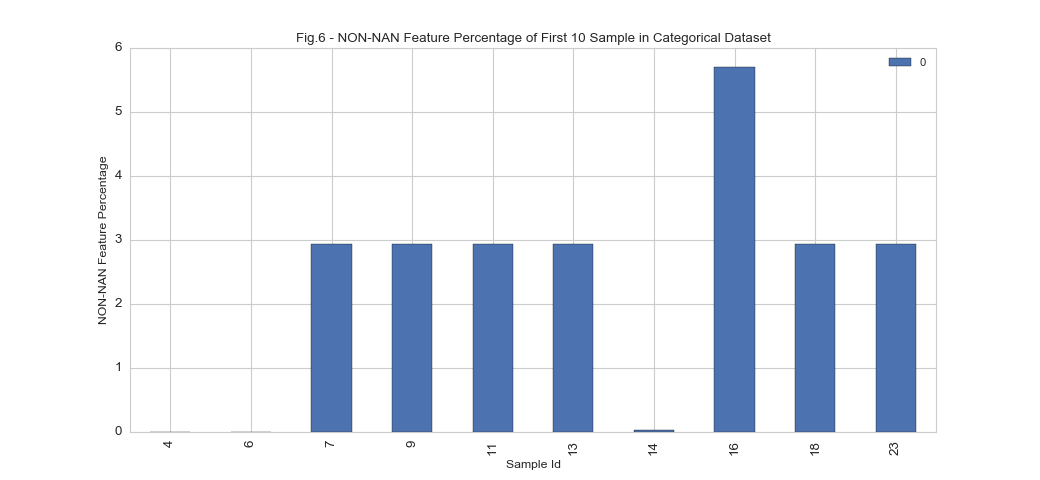

In [294]:
ax = df_a.transpose().plot( kind="bar",
                             title="Fig.6 - NON-NAN Feature Percentage of First 10 Sample in Categorical Dataset",
                             figsize=(13,6), fontsize=12)
ax.set_xlabel("Sample Id")
ax.set_ylabel("NON-NAN Feature Percentage")

In [260]:
sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Fig.4 - Features by Station",
                             figsize=(13,6), fontsize=12)

KeyError: 'Sample'

In [190]:
train_categorical_zeroes_array[train_categorical_zeroes_array!=0.0]

array(['T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T

In [191]:
np.unique(train_categorical_zeroes_array[train_categorical_zeroes_array!=0.0])

array(['T1', 'T145', 'T3'], dtype=object)

In [192]:
train_categorical_hd = pd.read_csv('data/train_categorical.csv',nrows = 10)

In [239]:
def exploreNoValuePart():
    noValue = []
    pd.read_csv('data/train_categorical.csv',nrows = 10)
    #   del train_categorical['Id']
    train_categorical_zeroes = train_categorical.fillna(0)
    train_categorical_zeroes_array = train_categorical_zeroes.values
    for i in range(10):
        train_categorical_zeroes_array_row = train_categorical_zeroes_array[i,:]
        noValue[i] = (train_categorical_zeroes_array_row[train_categorical_zeroes_array_row!=0.0].size-1)/float(
            train_categorical_zeroes_array_row).size
    return noValue
        

SyntaxError: invalid syntax (<ipython-input-239-c701bafdf01f>, line 11)

In [240]:
noValue = exploreNoValuePart()

TypeError: only length-1 arrays can be converted to Python scalars